# Setting Up

## Conexión a drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#  !!!! ES NECESARIO EDITAR CON EL PATH CORRESPONDIENTE  !!!!
%cd drive/MyDrive/'Colab Notebooks/TTT-2020-1-16'

/content/drive/MyDrive/Colab Notebooks/TTT-2020-1-16


In [4]:
%pwd

'/content/drive/MyDrive/Colab Notebooks/TTT-2020-1-16'

## Importar los módulos *_utils

In [5]:
import sys
#  !!!! ES NECESARIO EDITAR CON EL PATH CORRESPONDIENTE  !!!!
sys.path.append('/content/drive/My Drive/Colab Notebooks/TTT-2020-1-16')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

# Funciones locales

## fcNeuralNetworkModel()

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def fcNeuralNetworkModel(task, params, optimizer, verbose = False):
    """
    Defines and compiles a new Keras model for a Fully Connected Neural Network
    with 1 hidden layer (a total of 3 layers) and dropout regularization.
    The number of units per layer, the activation function, the regularization 
    rate and the are given by the params dictionary.

    """
    VEC_EMBEDDINGS_DIM = 300
    activation_f = params['activation']

    input_vector = keras.Input(name='INPUT', shape=(VEC_EMBEDDINGS_DIM), dtype="float64")

    x  = layers.Dense(units=params['L1_size'], 
                              activation=activation_f, 
                              name = 'DL_1')(input_vector)

    x = layers.Dropout(rate=params['p_dropout_1'], name = 'DROPOUT_1')(x)                              

    x = layers.Dense(units=params['L2_size'], 
                              activation=activation_f, 
                              name = 'DL_2')(x)                          

    x = layers.Dropout(rate=params['p_dropout_2'], name = 'DROPOUT_2')(x)

    if task in ['HS', 'TR', 'AG']:
      preds = layers.Dense(1, activation="sigmoid", name = 'PREDICTOR')(x)
      model = keras.Model(input_vector, preds)

      model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

    elif task == 'HTA':
      preds = layers.Dense(5, activation="softmax", name = 'PREDICTOR')(x)
      preds = reshape = layers.Reshape(target_shape=(5,))(preds)

      model = keras.Model(input_vector, preds)
      model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["acc"])

    if verbose:
      model.summary()

    return model

# EXPERIMENTOS

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='SINGLE-VEC',
                                                 labels_to_return=['AG'],
                                                 n_folds=7)

FastText 3 - Spanish Unannotated Corpora
Encoding Format: SINGLE-VEC

Process complete
5000 train instances retrieved

encodings_dim = (300,)


# Búsqueda número 1

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

arch_params_dict = {
    'L1_size': [400, 300, 200],                    
    'L2_size': [150, 100, 75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.5],
    'p_dropout_2':[0.5]                                
}

arch_params_combos = list(product( *arch_params_dict.values() ))          

arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

9 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4'],
                       'batch_size':[256,512,1024],
                       'max_epochs':[75]}
                        

trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


18 trainig_params_combos.


**Combinaciones (arquitectura) x (entrenamiento)**

In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


162 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          fcNeuralNetworkModel, 
                          search_space,
                          arch_params_dict.keys(),
                          trainig_params_dict.keys(),
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/SNN/AG/experiments_1.df',
                          backup_freq=25,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [6]:
import pickle
with open('./Results/SNN/AG/experiments_1.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [7]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,L1_size,L2_size,activation,p_dropout_1,p_dropout_2,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
114,hmswjNVN,400,75,relu,0.5,0.5,adam-1e-4,256,75,62,0.779268,0.791741,32,72,54.0,0.764803,0.796290
121,NZkDWeRs,400,75,relu,0.5,0.5,rmsprop-5e-4,512,75,53,0.813509,0.791042,31,65,53.0,0.807443,0.795594
86,cEytKBkG,400,150,relu,0.5,0.5,rmsprop-5e-4,1024,75,47,0.774601,0.789993,42,66,55.5,0.789067,0.796996
118,KhZQpZiy,400,75,relu,0.5,0.5,rmsprop-1e-3,512,75,59,0.825818,0.789988,32,59,48.5,0.794026,0.799790
117,HhmPpZGS,400,75,relu,0.5,0.5,rmsprop-1e-3,256,75,49,0.833868,0.789645,27,67,53.0,0.831654,0.798042


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


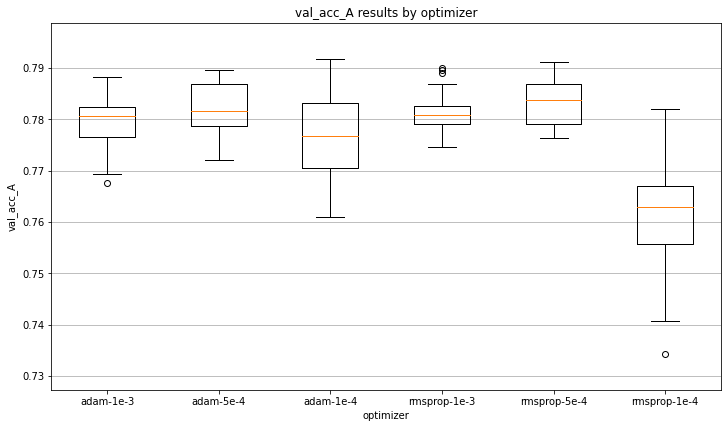

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


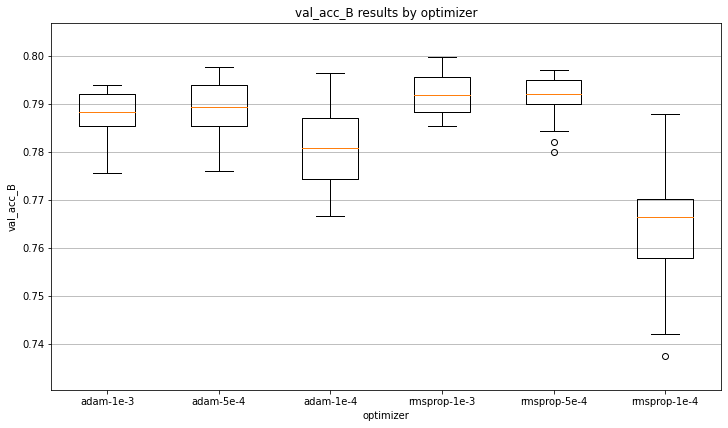

In [8]:
params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 
                            'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4']                                
}

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

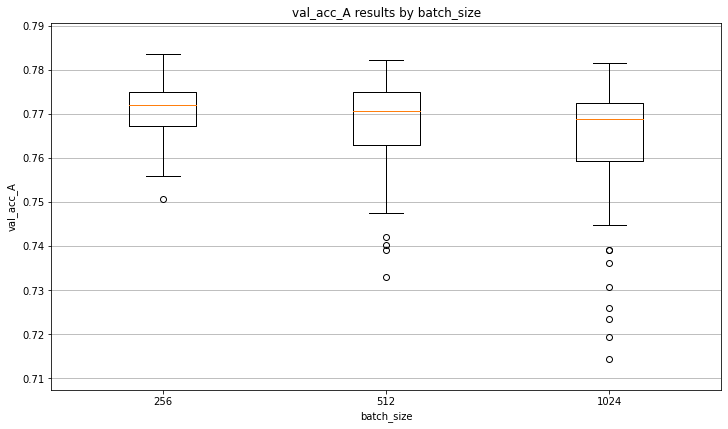

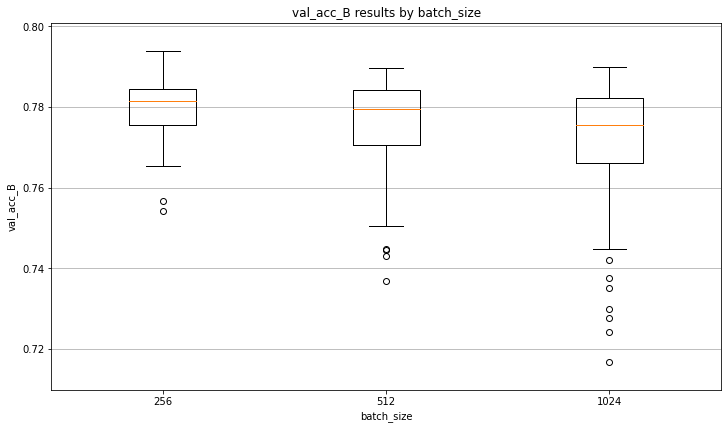

In [ ]:
results_utils.plotResultsByParameter1(results_df, 
                       {'batch_size':[256,512,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       {'batch_size':[256,512,1024]}, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

### Resumen de los resultados

* optimizador: ['adam-1e-3','adam-5e-4'], ['adam-1e-4','rmsprop-5e-4']
* batch_size [256,512]

# Búsqueda número 2

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

arch_params_dict = {
    'L1_size': [500, 400, 300, 200],                    
    'L2_size': [200, 150, 100, 75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5,0.75],
    'p_dropout_2':[0.25,0.5,0.75]                                
}

arch_params_combos = list(product( *arch_params_dict.values() ))          

arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

96 arch_params_combos.


**Parámetros de entrenamiento**

In [ ]:
trainig_params = {'optimizer':['adam-5e-4', 'rmsprop-5e-4'],
                    'batch_size':[256],
                    'max_epochs':[75]}
                        
trainig_params_combos = list(product( *trainig_params.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos)))


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


192 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          fcNeuralNetworkModel, 
                          search_space,
                          arch_params_dict.keys(),
                          trainig_params_dict.keys(),
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/SNN/AG/experiments_2.df',
                          backup_freq=25,
                          save_history_files=True,
                          save_models_as_json=False)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head(5)

,conf_ID,L1_size,L2_size,activation,p_dropout_1,p_dropout_2,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
90,vBuAbLvC,400,75,relu,0.75,0.25,adam-5e-4,256,75,65,0.725952,0.738539,58,70,0.726885,0.742040
86,stzSDXGW,400,75,relu,0.50,0.25,adam-5e-4,256,75,33,0.726536,0.738190,24,61,0.742226,0.740291
26,jHuCrbhB,500,100,relu,0.50,0.25,adam-5e-4,256,75,25,0.703552,0.733992,12,54,0.728164,0.743442
137,iJdkgsov,300,75,relu,0.50,0.50,adam-5e-4,512,75,72,0.775186,0.733292,50,64,0.734118,0.742041
29,LGxgjEhS,500,100,relu,0.50,0.50,adam-5e-4,512,75,45,0.724435,0.733289,32,68,0.737910,0.743793


## Resultados

In [9]:
import pickle
with open('./Results/SNN/AG/experiments_2.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [10]:
params_dict = {
    'L1_size': [500, 400, 300, 200],                    
    'L2_size': [200, 150, 100, 75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5,0.75],
    'p_dropout_2':[0.25,0.5,0.75]                                
}

**Resultados por parámetro**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


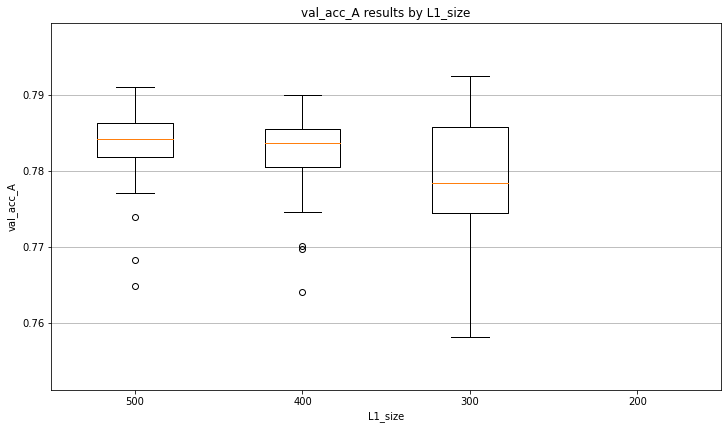

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


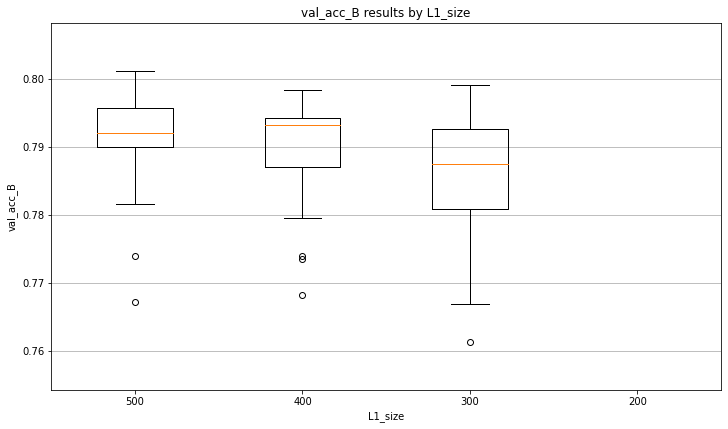

In [11]:
results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['L1_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['L1_size'],
                       metric='val_acc_B')

**L1_size >= 400**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


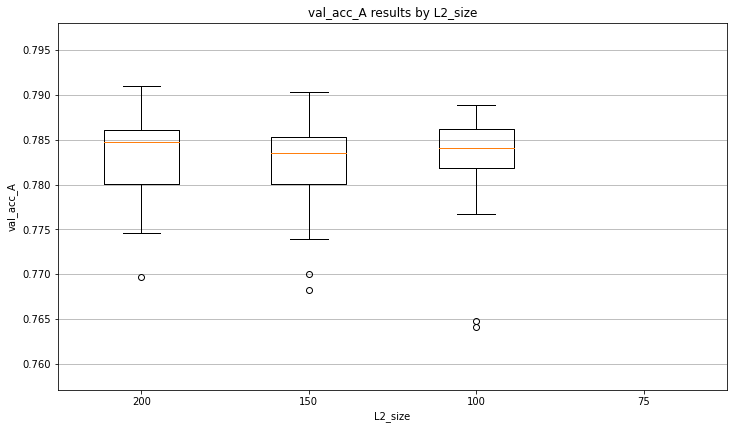

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


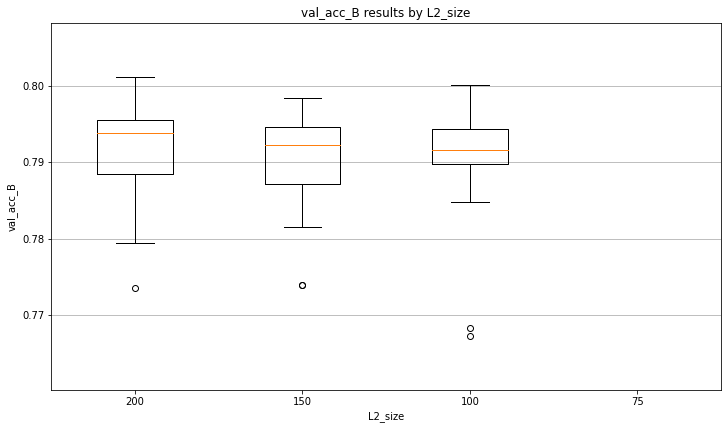

In [12]:
L1_mask = results_df['L1_size']>= 400
results_subset = results_df.loc[L1_mask]

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['L2_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['L2_size'],
                       metric='val_acc_B')

**L2_size <= 100**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


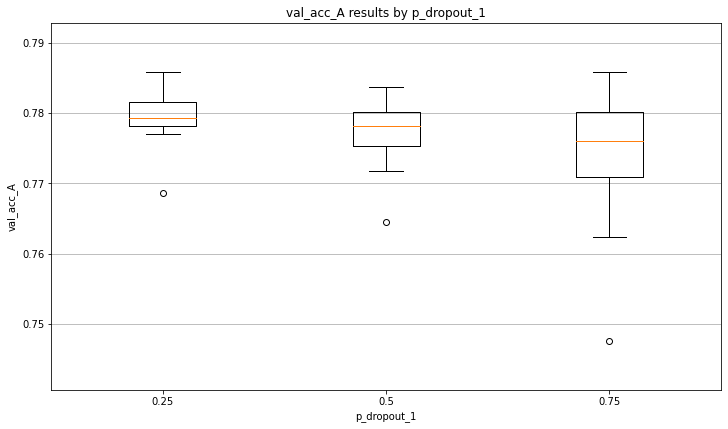

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


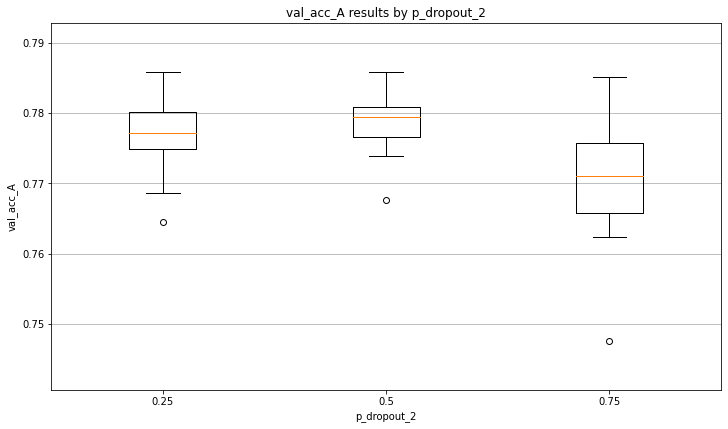

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


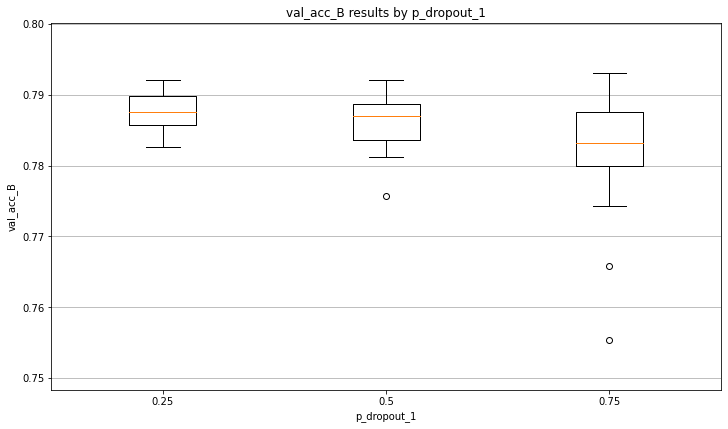

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


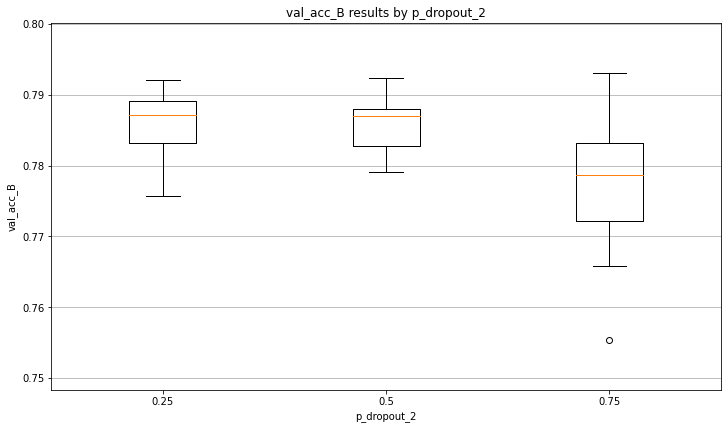

In [ ]:
L1_mask = results_df['L1_size']>= 400
L2_mask = results_df['L2_size']<= 100

results_subset = results_df.loc[L1_mask & L2_mask]

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['p_dropout_1', 'p_dropout_2'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['p_dropout_1', 'p_dropout_2'],
                       metric='val_acc_B')

### Resumen de los resultados
* L1_size >= 400
* L2_size <= 100
* p_dropout_1 = [0.5]
* p_dropout_2 = [0.5,**0.25**]


* optimizador: ['adam-1e-3','adam-5e-4'], ['adam-1e-4','rmsprop-5e-4']
* batch_size [256,512]

# Búsqueda número 3

### Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

arch_params_dict = {
    'L1_size': [550,500,450,400],                    
    'L2_size': [125,100,75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5],
    'p_dropout_2':[0.25,0.5]                                
}

arch_params_keys = arch_params_dict.keys()
arch_params_combos = list(product( *arch_params_dict.values() ))          

arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

36 arch_params_combos.


**Parámetros de entrenamiento**

In [ ]:
trainig_params_dict = {'optimizer':['adam-5e-4', 'rmsprop-5e-4'],
                    'batch_size':[256],
                    'max_epochs':[75]}
                        
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos)))


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


72 params combinations in the search_space.


### Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          fcNeuralNetworkModel, 
                          search_space[:],
                          arch_params_dict.keys(),
                          trainig_params_dict.keys(),
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/SNN/AG/experiments_3.df',
                          backup_freq=25,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [13]:
import pickle
with open('./Results/SNN/AG/experiments_3.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

In [ ]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

In [ ]:
params_dict = {
    'L1_size': [550,500,450,400],                    
    'L2_size': [125,100,75],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5],
    'p_dropout_2':[0.25,0.5]                                
}

**Resultados por parámetro**

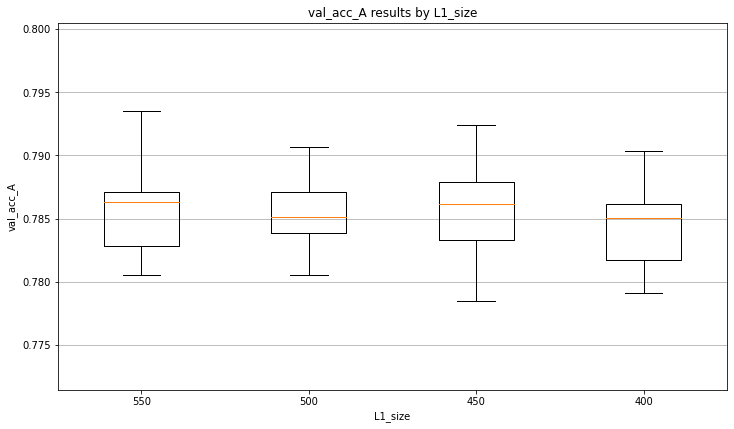

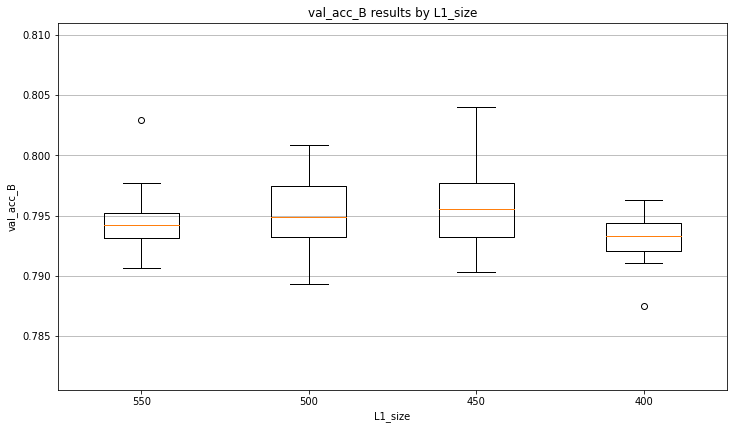

In [ ]:
results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['L1_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_df, 
                       params_dict, 
                       params2plot=['L1_size'],
                       metric='val_acc_B')

**L1_size >= 400**

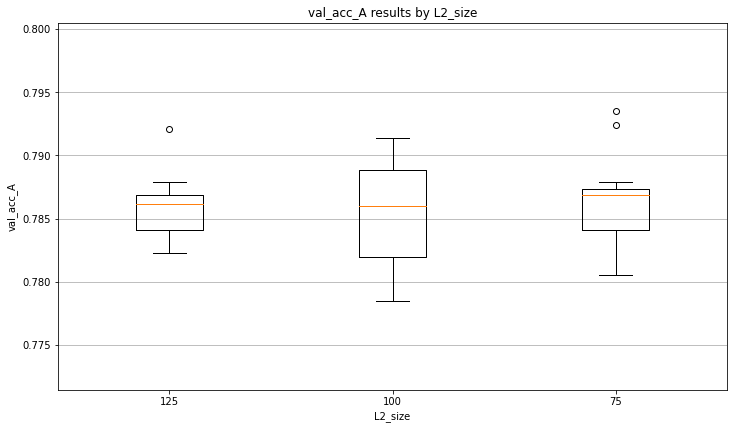

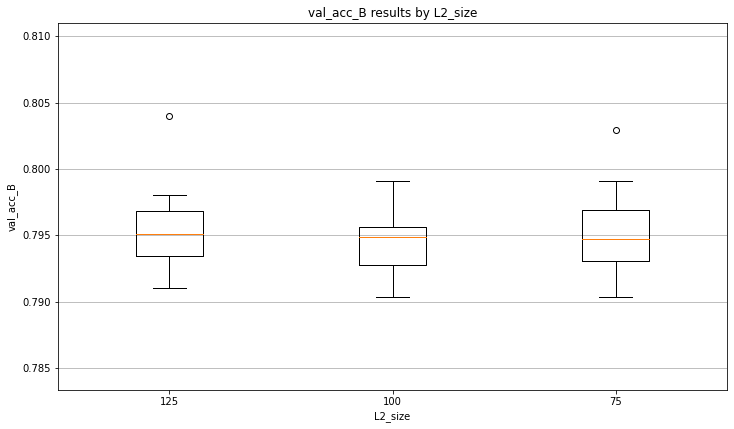

In [ ]:
L1_mask = results_df['L1_size'].isin([450,550])
results_subset = results_df.loc[L1_mask]

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['L2_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(results_subset, 
                       params_dict, 
                       params2plot=['L2_size'],
                       metric='val_acc_B')

### Resumen de los resultados
* L1_size = [400,550]
* L2_size = [100,75]
* p_dropout_1 = [0.5]
* p_dropout_2 = [0.5,**0.25**]


* optimizador: ['adam-1e-3','adam-5e-4'], ['adam-1e-4','rmsprop-5e-4']
* batch_size [256,512]

# Búsqueda número 4

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

arch_params_dict = {
    'L1_size': [550,450],                    
    'L2_size': [125,100],                
    'activation':['relu'],                                    
    'p_dropout_1':[0.25,0.5],
    'p_dropout_2':[0.25,0.5]                                
}

arch_params_keys = arch_params_dict.keys()
arch_params_combos = list(product( *arch_params_dict.values() ))          

arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

12 arch_params_combos.


**Parámetros de entrenamiento**

In [ ]:
trainig_params_dict = {'optimizer':['adam-5e-4', 'rmsprop-5e-4'],
                    'batch_size':[256, 512],
                    'max_epochs':[75]}
                        
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos)))


4 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'AG',
                          fcNeuralNetworkModel, 
                          search_space,
                          arch_params_dict.keys(),
                          trainig_params_dict.keys(),
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=False,
                          backup_file='./Results/SNN/AG/experiments_4.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=True,
                          save_weights=True)

## Resultados

In [17]:
import pickle
with open('./Results/SNN/AG/experiments_4.df', 'rb') as file_handler:
  results_df = pickle.load(file_handler)

results_df.shape

(24, 17)

In [18]:
results_df.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,L1_size,L2_size,activation,p_dropout_1,p_dropout_2,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
17,WSUJpwQP,450,150,relu,0.50,0.25,adam-5e-4,512,75,43,0.805500,0.798198,22,62,33,0.797466,0.804798
16,kpsolZbm,450,150,relu,0.50,0.25,adam-5e-4,256,75,28,0.793634,0.794597,23,31,28,0.790967,0.799398
9,FljeuYPX,550,150,relu,0.50,0.50,adam-5e-4,512,75,35,0.780467,0.791398,34,65,40,0.803902,0.799997
6,MAIRzcUI,550,150,relu,0.50,0.25,rmsprop-5e-4,256,75,25,0.795200,0.790394,16,41,23,0.791469,0.798395
13,ctvTiuoq,450,150,relu,0.25,0.25,adam-5e-4,512,75,21,0.778100,0.790393,17,35,21,0.789101,0.798195


In [ ]:
results_df.sort_values(by='val_acc_B', ascending=False).head()

# Resources

* Mini batch size selection: [1](https://datascience.stackexchange.com/questions/18414/are-there-any-rules-for-choosing-the-size-of-a-mini-batch), [2](https://www.quora.com/In-deep-learning-why-dont-we-use-the-whole-training-set-to-compute-the-gradient), [3](https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu)
* Optimizers: [1](https://ai.stackexchange.com/questions/18206/what-kind-of-optimizer-is-suggested-to-use-for-binary-classification-of-similar)
* RMSprop: [1](https://towardsdatascience.com/understanding-rmsprop-faster-neural-network-learning-62e116fcf29a)
* Number of Hidden Layers: [1](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw)

    
